# Zadania - wielomiany ortogonalne.

## Zadanie 3

Zacznijmy od ponownego zdefiniowania funkcji z poprzednich zajęć. Wyznaczmy też wielomian aproksymacjyjny:

In [1]:
getS(x,m) = [sum(x.^(i+j)) for i = 0:m, j = 0:m]
gett(x,y,m) = transpose([y'*x.^k for k = 0:m])
fitpoly(x,y,m) = gett(x,y,m)/getS(x,m)

fitpoly (generic function with 1 method)

In [2]:
fitdata(X,m,a) = reduce(hcat,[X.^i for i = 0:m])  *  a' 

fitdata (generic function with 1 method)

In [3]:
MSE(Ŷ,Y) = sum((Ŷ - Y).^2)

MSE (generic function with 1 method)

In [4]:
X = [0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5]
Y = [1.02, 0.62, 0.5, 0.6, 0.98, 1.55, 3.12, 5.08];
m = 2;
X₂=X[X .!= 2.5]
Y₂ = Y[Y .!= Y[findfirst(x -> x == 2.5,X)]];

In [5]:
fitpoly(X,Y,2) 

1×3 transpose(::Vector{Float64}) with eltype Float64:
 1.18125  -1.64083  0.77119

Teraz zdefiniujmy funkcję która znajdzie wielomiany ortogonalne metodą Grama-Schmidta:

In [6]:
function gram_schmidt_solve(X,Y,m)
    w = Array{Array{Float64}}(undef, m+1)  
    a = zeros(Float64, (m+1, m+1))
    α = zeros(Float64,m+1)
    for i = 0:m
        wᵢ = X.^i
        a[i+1, i+1] = 1.0
        for j = 1:i
            aⱼ = (w[j]'*wᵢ)/sum(w[j].^2)
            a[i+1, :] -= aⱼ.*a[j,:]
            wᵢ -= aⱼ * w[j]
        end
        w[i+1] = wᵢ
        α[i+1] = sum(wᵢ .* Y)/sum(wᵢ.^2)
    end
    return α' * a
end

gram_schmidt_solve (generic function with 1 method)

Rozwiążmy zadanie:

In [7]:
gram_schmidt_solve(X₂,Y₂,2)

1×3 adjoint(::Vector{Float64}) with eltype Float64:
 1.12442  -1.4947  0.738715

## Zadanie

Zbadajmy teraz to jak efektywna obliczeniowo są wielomiany ortogonalne (zadanie zaadopotwane z podręcznika [Introduction to Applied Linear Algebra – Vectors, Matrices, and Least Square Introduction to Applied Linear Algebra – Vectors, Matrices, and Least Squares, strona 102](https://web.stanford.edu/~boyd/vmls/vmls-julia-companion.pdf))

In [8]:
# Generate data in the interval [-1, 1].
using Random; Random.seed!(232)
m = 100;
t = -1 .+ 2*rand(m);
y = t.^3 - t + 0.4 ./ (1 .+ 25*t.^2) + 0.10*randn(m);

Pokażmy dane na wykresie:

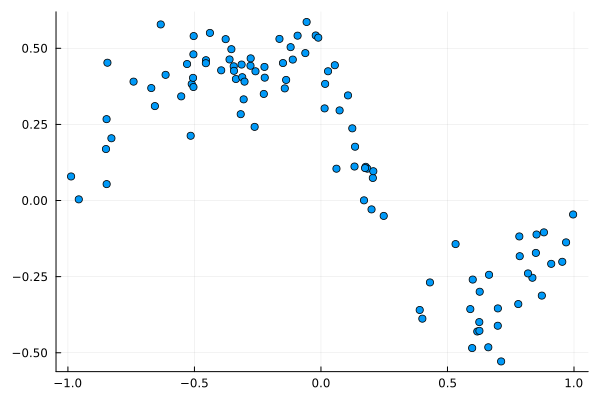

In [9]:
using Plots
scatter(t,y,legend=false)

Sprawdźmy najpierw jak zachowują się błędy w porównaniu z rozwiązaniem bazowym:

In [10]:
#Generate the test set.
m = 100;
t_test = -1 .+ 2*rand(m,1)
y_test = t_test.^3 - t_test + 0.4 ./ (1 .+ 25*t_test.^2) + 0.10*randn(m,1);

In [11]:
error_train = zeros(21);
error_train_gs = zeros(21);
error_test = zeros(21);
error_test_gs = zeros(21);

In [12]:
for p = 1:21
    α = fitpoly(t,y,p)
    error_train[p] = MSE(fitdata(t,p,α),y) 
    error_test[p] = MSE(fitdata(t_test,p,α),y_test)
    a = gram_schmidt_solve(t,y,p)
    error_train_gs[p] = MSE(fitdata(t,p,a),y) 
    error_test_gs[p] = MSE(fitdata(t_test,p,a),y_test)
end


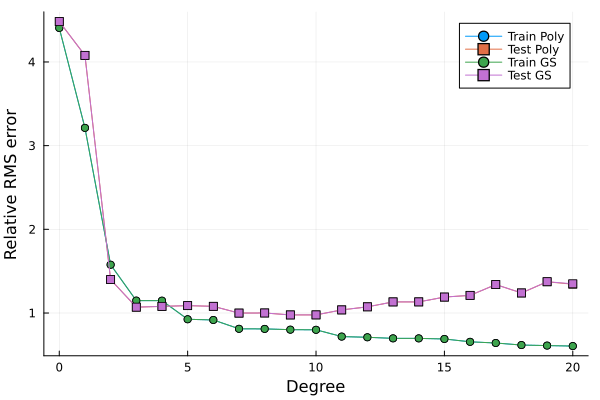

In [13]:
plot(0:20, error_train, label = "Train Poly", marker = :circle)
plot!(0:20, error_test, label = "Test Poly", marker = :square)
plot!(0:20, error_train_gs, label = "Train GS", marker = :circle)
plot!(0:20, error_test_gs, label = "Test GS", marker = :square)
plot!(xlabel="Degree", ylabel = "Relative RMS error")

Sprawdźmy teraz jaka jest różnica w szybkości pomiędzy oboma rozwiązaniami. Użyjemy do tego biblioteki [<tt>BechmarkTools.jl</tt>](https://github.com/JuliaCI/BenchmarkTools.jl). Pozwala ona na efektywne badanie wydajności kodu w Julii. W porównaniu z wbudowanymi w język makrami <tt>@time</tt> i <tt>@elapsed</tt>, makra <tt>@btime</tt> i <tt>@belapsed</tt> są znacznie bardziej odporne na procesy w tle, kompliowanie kodu i inne formy losowego szumu, które mogą zaburzyć wynik benchmarku.

Wykorzystamy makro <tt>@belapsed</tt>, które zwraca przeciętny czas wykonywania algorytmu w formie zmiennej (dla porównania, makro <tt>@btime</tt> printuje wynik).

In [14]:
#import Pkg; Pkg.add("BenchmarkTools")

In [15]:
using BenchmarkTools

In [16]:
time_fitpoly=zeros(length(1:0.5:5));
time_gs=zeros(length(1:0.5:5));

In [21]:
for (i,p) in enumerate(1:0.5:5)
    m = ceil(Int,10^p)
    t = -1 .+ 2*rand(m);
    y = t.^3 - t + 0.4 ./ (1 .+ 25*t.^2) + 0.10*randn(m);
    t1 = @belapsed fitpoly(t,y,3)
    time_fitpoly[i] = t1
    t2 = @belapsed gram_schmidt_solve(t,y,3)
    time_gs[i] = t2
    @info "For $m points; fitpoly: $t1, gram_schmidt_solve: $t2"
end

[ Info: For 10 points; fitpoly: 1.9888888888888887e-6, gram_schmidt_solve: 1.76e-5
[ Info: For 32 points; fitpoly: 3.6625e-6, gram_schmidt_solve: 1.81e-5
[ Info: For 100 points; fitpoly: 8.333333333333334e-6, gram_schmidt_solve: 2.03e-5
[ Info: For 317 points; fitpoly: 2.41e-5, gram_schmidt_solve: 2.93e-5
[ Info: For 1000 points; fitpoly: 7.07e-5, gram_schmidt_solve: 4.54e-5
[ Info: For 3163 points; fitpoly: 0.0002219, gram_schmidt_solve: 0.0001092
[ Info: For 10000 points; fitpoly: 0.0007108, gram_schmidt_solve: 0.0003644
[ Info: For 31623 points; fitpoly: 0.002526, gram_schmidt_solve: 0.0014828
[ Info: For 100000 points; fitpoly: 0.0075402, gram_schmidt_solve: 0.0040829


Wygenerujmy wykres:

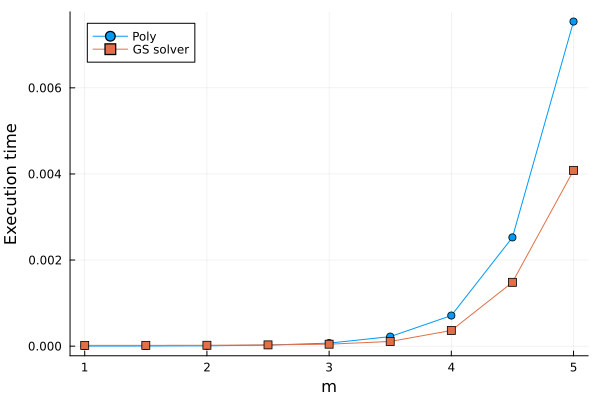

In [24]:
plot(1:0.5:5, time_fitpoly, label = "Poly", marker = :circle)
plot!(1:0.5:5, time_gs, label = "GS solver", marker = :square)
plot!(xlabel="m", ylabel = "Execution time")

<b>Zadanie dodatkowe (10 punktów):</b> zoptymalizuj funkcję <tt>gram_schmidt_solve</tt> tak żeby działała szybciej niż jej forma prezentowana na zajęciach.